In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as datetime
import scipy.stats as st
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

plt.style.use('ggplot')

In [2]:
#import the Sign window (only B / S)
sign_windows = pd.read_excel('Ensemble_Window_Signals_12.31.20.xlsx', sheet_name='Gold Window Signals', index_col=0, parse_dates=True)
print('Number of significant windows: ' + str(len(sign_windows.columns)))

Number of significant windows: 254


In [3]:
#Train sign window
train_start_date = sign_windows.index.min()
train_end_date = pd.Timestamp('12-31-2004')
train_sign_windows = sign_windows[:train_end_date]

#Test sign window
test_start_date = pd.Timestamp('01-31-2005')
test_end_date = pd.Timestamp('12-31-2020')
test_sign_windows = sign_windows[test_start_date:test_end_date]

#two_returns only with B / S signals
two_returns = pd.read_excel('Ensemble_Window_Signals_12.31.20.xlsx', sheet_name = 'Gold Returns', index_col=[0], parse_dates=True)
two_returns = two_returns.iloc[1:, :]

#divide into three chunks, train, validation, and test
train_two_returns = two_returns[:train_end_date]
test_two_returns = two_returns[test_start_date:test_end_date]

In [4]:
#Creating train_return_windows

data_index = train_sign_windows.index
data_columns = train_sign_windows.columns

train_return_windows = pd.DataFrame(columns=train_sign_windows.columns, index=train_sign_windows.index)

for index in range(train_sign_windows.shape[0]):
    
    b_return = train_two_returns.iloc[index, 0]
    s_return = train_two_returns.iloc[index, 1]

    for col in range(train_sign_windows.shape[1]):
        if train_sign_windows.iloc[index, col] == 'B':
            train_return_windows.iloc[index, col] = b_return
        else:
            train_return_windows.iloc[index, col] = s_return
        

In [5]:
#Creating test_return_windows
data_index = test_sign_windows.index
data_columns = test_sign_windows.columns

test_return_windows = pd.DataFrame(columns=test_sign_windows.columns, index=test_sign_windows.index)


for index in range(test_sign_windows.shape[0]):
    
    b_return = test_two_returns.iloc[index, 0]
    s_return = test_two_returns.iloc[index, 1]

    for col in range(test_sign_windows.shape[1]):
        if test_sign_windows.iloc[index, col] == 'B':
            test_return_windows.iloc[index, col] = b_return
        else:
            test_return_windows.iloc[index, col] = s_return
        

In [6]:
def ann_return(series, frequency="Monthly"):
    freq_dict = {"Daily": 252, "Monthly": 12, "Quarterly": 4, "Yearly": 1}
    return np.prod(series + 1) ** (freq_dict[frequency] / len(series)) - 1

def ann_stdev(series, frequency="Monthly"):
    freq_dict = {"Monthly": 12, "Quarterly": 4, "Yearly": 1}
    return np.std(series, axis=0) * np.sqrt(freq_dict[frequency])

def trade_count(series):
    count = (series != series.shift()).cumsum()[-1]
    return int(count)

In [7]:
def threshold(frame, threshold, buffer):

    
    buy_strength = frame.apply(lambda row: row.value_counts(normalize=True), axis=1)['B']
    buy_strength = buy_strength.fillna(0)
    
    buy_filter = buy_strength > threshold
    sell_filter = buy_strength < (threshold - buffer)
    
    buy_strength[buy_filter] = 'B'
    buy_strength[sell_filter] = 'S'
    
    buy_strength[buy_strength.apply(lambda x: isinstance(x, float))] = np.nan
    buy_strength = buy_strength.fillna(method='ffill')
    
    return buy_strength

def signal_transform(frame, buy_signal, buy_series, sell_series, shift=True):

    if shift:
        frame = frame.shift()
        frame = frame.dropna()
        
    buy_series = buy_series.iloc[1:,]
    sell_series = sell_series.iloc[1:,]
#     reindex would cause NA
#     buy_series = buy_series.reindex(frame.index)
#     sell_series = sell_series.reindex(frame.index)
    

    new_frame = frame.apply(lambda x: np.where(x == buy_signal, buy_series, sell_series))
    
    return new_frame

In [8]:
train_ens_signals = threshold(train_sign_windows, 0.75, 0.5)

train_ens_thresh_returns = signal_transform(pd.DataFrame(train_ens_signals), buy_signal='B', buy_series=train_two_returns['Buy Index'], sell_series=train_two_returns['Sell Index'],)

# Equal-weighted (Current Model) - Train
print(ann_return(train_ens_thresh_returns))
print(ann_stdev(train_ens_thresh_returns))
print(trade_count(train_ens_signals))

B    0.143066
dtype: object
B    0.140276
dtype: float64
4


In [9]:
test_ens_signals = threshold(test_sign_windows, 0.75, 0.5)
test_ens_signals.head()
test_ens_thresh_returns = signal_transform(pd.DataFrame(test_ens_signals), buy_signal='B', buy_series=test_two_returns['Buy Index'], sell_series=test_two_returns['Sell Index'],)

# Equal-weighted (Current Model) - Test
print(ann_return(test_ens_thresh_returns))
print(ann_stdev(test_ens_thresh_returns))
print(trade_count(test_ens_signals))

B    0.160772
dtype: object
B    0.16299
dtype: float64
3


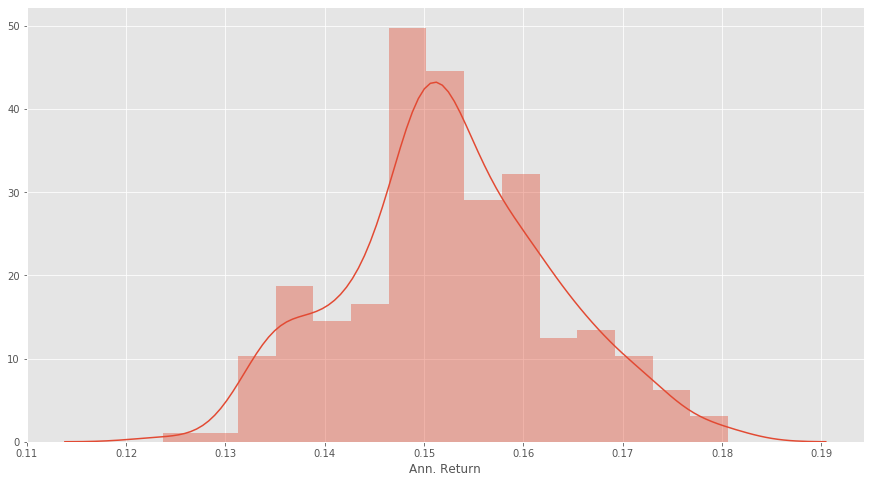

In [10]:
win_frame = pd.DataFrame({'Ann. Return': train_return_windows.apply(ann_return),
                          'Ann. Vol': train_return_windows.apply(ann_stdev),
                          'Trade Count': train_sign_windows.apply(trade_count)})
win_frame.round(4)

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(win_frame['Ann. Return'], ax=ax)

In [11]:
sharpe_ratio = np.array(win_frame['Ann. Return']/win_frame['Ann. Vol'])

from sklearn.preprocessing import StandardScaler

#sharpe_ratio = np.array(win_frame['Ann. Return'])

scaler = StandardScaler()
sharpe_ratio = sharpe_ratio.reshape(-1, 1)
scaler.fit(sharpe_ratio)
sharpe_trans = scaler.transform(sharpe_ratio)

In [12]:
num_1 = [0.75, 0.9, 0.7, 0.8, 0.8, 0.9, 0.9, 0.7]
num_2 = [0.50, 0.6, 0.4, 0.6, 0.5, 0.7, 0.5, 0.5]

num_sum = len(num_1)


In [13]:
#A new threshold function to get the signals
def threshold(frame, threshold, buffer):

    
#     buy_strength = frame.apply(lambda row: row.value_counts(normalize=True), axis=1)['B']
#     buy_strength = buy_strength.fillna(0)

    buy_strength = frame
    
    buy_filter = buy_strength > threshold
    sell_filter = buy_strength < (threshold - buffer)
    
    buy_strength[buy_filter] = 'B'
    buy_strength[sell_filter] = 'S'
    
    buy_strength[buy_strength.apply(lambda x: isinstance(x, float))] = np.nan
    buy_strength = buy_strength.fillna(method='ffill')
    
    return buy_strength

In [15]:
for the_thre_num in range(num_sum):

    eafe_return = []
    eafe_vol = []
    trade_c = []
    
    #change the sharpe ratio for different models
    sharpe_ratio = np.array(win_frame['Ann. Return'])

    scaler = StandardScaler()
    sharpe_ratio = sharpe_ratio.reshape(-1, 1)
    scaler.fit(sharpe_ratio)
    sharpe_trans = scaler.transform(sharpe_ratio)
    
    for num in range(1, 21):
        sharpe_exp = np.exp(sharpe_trans * num)

        overall = np.sum(sharpe_exp)
        weights = [value / overall for value in sharpe_exp]
        weights = np.array(weights)

        train_sign_windows_binary = np.where(train_sign_windows == 'B', 1, 0)
        train_weighted_buy = train_sign_windows_binary @ weights


    
        train_index = train_sign_windows.index
        train_weighted_buy = pd.DataFrame(train_weighted_buy, index = train_index )
        train_weighted_buy = train_weighted_buy.iloc[:,0]
    
        train_ens_signals = threshold(train_weighted_buy, num_1[the_thre_num], num_2[the_thre_num])
    
        train_ens_thresh_returns = signal_transform(pd.DataFrame(train_ens_signals), buy_signal='B', buy_series=train_two_returns['Buy Index'], sell_series=train_two_returns['Sell Index'],)
    
        trade_c.append(int(trade_count(train_ens_signals)))

        eafe_return.append(float(ann_return(train_ens_thresh_returns)))
    
        eafe_vol.append(float(ann_stdev(train_ens_thresh_returns)))
        
    d = {'eafe_return': eafe_return, 'eafe_vol':eafe_vol , 'trade_count': trade_c}
    kk = pd.DataFrame(data = d, index = range(1,21) )
    
    #change the title name for different models
    title_name = 'Gold_Train_' + str(int(num_1[the_thre_num] * 100)) + '_' + str(int(num_1[the_thre_num] * 100 - num_2[the_thre_num] * 100 )) + '_onlyreturn.csv'

    kk.to_csv(title_name)